<a href="https://colab.research.google.com/github/mikeusru/neural-network-training/blob/main/4_captcha_breaking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breaking Captchas with Machine Learning
You're trying to buy a super hot product which is flying off the web-shelves before you can click "add to cart". To add to the problem, you decide to build a bot which will automatically add and checkout for you as soon as the product goes on sale. But there's a catch - a CAPTCHA! 

Luckily you've taken a data science course and know captchas are just for n00bs, who you're gonna pwn. (That's late 90s/early 2000s internet lingo).

Luckily, you realize the website you're working with uses an open-source CAPTCHA technique. If this wasn't the case, you'd need to scrape a bunch of captchas yourself and manually label them. This way, you can generate them yourself with auto-labels. Yay!

Here's the code for our captcha generating software, in case you want to check it out.

https://wordpress.org/plugins/really-simple-captcha/

By the way, this notebook is an adaptation from Adam Geitgory's fantastic article, which you can find here:
https://medium.com/@ageitgey/how-to-break-a-captcha-system-in-15-minutes-with-machine-learning-dbebb035a710

By looking at the source code, we see how captchas are being created...



```
public function __construct() {
		/* Characters available in images */
		$this->chars = 'ABCDEFGHJKLMNPQRSTUVWXYZ23456789';

		/* Length of a word in an image */
		$this->char_length = 4;

		/* Array of fonts. Randomly picked up per character */
		$this->fonts = array(
			dirname( __FILE__ ) . '/gentium/GenBkBasR.ttf',
			dirname( __FILE__ ) . '/gentium/GenBkBasI.ttf',
			dirname( __FILE__ ) . '/gentium/GenBkBasBI.ttf',
			dirname( __FILE__ ) . '/gentium/GenBkBasB.ttf',
		);
  ```

4 Characters, Letters and Numbers, not including Is and Os.



![captcha](https://miro.medium.com/max/4800/1*dC78m_XpcZmuaV_GlnAh5g.png)

So we collected (or created) a bunch of captchas. let's take a look at them (I've linked this notebook w/ my google drive, so I can pull the files in directly).

In [130]:
import glob
import os

CAPTCHA_IMAGE_FOLDER = os.path.join("drive", "MyDrive", "colab-data", "generated_captcha_images")

captcha_image_files = glob.glob(os.path.join(CAPTCHA_IMAGE_FOLDER, "*"))
[print(img_file) for img_file in captcha_image_files[:5]]

drive/MyDrive/colab-data/generated_captcha_images/BSKP.png
drive/MyDrive/colab-data/generated_captcha_images/L4LD.png
drive/MyDrive/colab-data/generated_captcha_images/T4XW.png
drive/MyDrive/colab-data/generated_captcha_images/EDFS.png
drive/MyDrive/colab-data/generated_captcha_images/YQYL.png


[None, None, None, None, None]

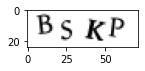

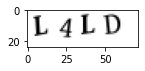

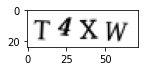

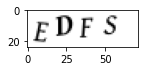

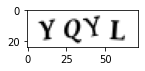

In [131]:
import cv2
import matplotlib.pyplot as plt

for img_file in captcha_image_files[:5] :
  img = cv2.imread(img_file) 
  plt.figure(figsize=(2,4))
  plt.imshow(img)

## Chopping up the images
At this point, we might be able to train an end-to-end network. However, the results might not be great, because decoding 4 letters in space is harder than just one. Perhaps we can simplify our problem by doing some smart preprocessing. Can we separate the characters in the captcha to identify just one at a time?

![Single letter annotation](https://miro.medium.com/max/4800/1*4ScTIDYJ6rPCAtopRulzOg.png)

Obviously we don't want to do this by hand for our 10,000 images (ew). So let's do it with OpenCV!

Our plan will be the following: Each letter is a "blob", or a region of pixels with a similar color. We want to identify the areas at the edges of these blobs, known as the "Contours". 

So we'll threshold our images, and then use cv2.findCountours()

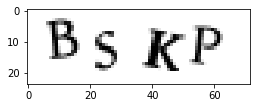

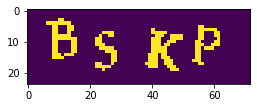

In [132]:
img = cv2.imread(captcha_image_files[0])
plt.figure(figsize=(4,8))
plt.imshow(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
plt.figure(figsize=(4,8))
plt.imshow(thresh)

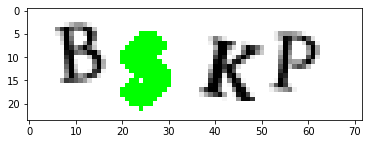

In [133]:
contours, heirarchy = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(cv2.drawContours(img.copy(), contours, 0, (0,255,0), 3))

The above image shows a single contour, which envelops the last letter. The contours divide our image into individual letters, however, there's a potential problem: what if letters overlap?

![overlapping image](https://miro.medium.com/max/1000/1*h0yC3aLQU1as2HnogUXjVQ.png)

In this case, there would be one big contour in the center, and it would contain two characters.

![thresh overlapping letters contour](https://miro.medium.com/max/1000/1*CaBtSHUmQ77E8zNi0C7wMQ.png)

To fix this issue, we can just split particularly wide contours down the middle.

![wide split](https://miro.medium.com/max/1000/1*ehE02z5AzBv1zt3UExB2_w.png)

In [134]:
letter_image_regions = []

for contour in contours:
  (x, y, w, h) = cv2.boundingRect(contour)
  # Compare the width and height of the contour to detect letters that
        # are conjoined into one chunk
  if w / h > 1.25:
      # This contour is too wide to be a single letter!
      # Split it in half into two letter regions!
      half_width = int(w / 2)
      letter_image_regions.append((x, y, half_width, h))
      letter_image_regions.append((x + half_width, y, half_width, h))
  else:
      # This is a normal letter by itself
      letter_image_regions.append((x, y, w, h))


Let's take a look at our regions!

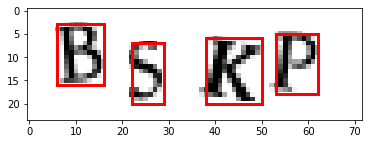

In [154]:
import matplotlib as mpl
fig, ax = plt.subplots()
ax.imshow(img)
for letter_image_region in letter_image_regions:
  rect = mpl.patches.Rectangle(letter_image_region[:2], letter_image_region[2], letter_image_region[3], facecolor='none', edgecolor='red', linewidth=3)
  ax.add_patch(rect)

Let's sort the letters based on the X coordinate so we're detecting left to right


In [136]:
letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
letter_image_regions

[(6, 3, 10, 13), (22, 7, 7, 13), (38, 6, 12, 14), (53, 5, 9, 13)]

Let's create labeled data now. To get the labels, we'll just extract the characters, in order, from the filenames.

In [160]:
filename = os.path.basename(captcha_image_files[0])
print(f"Filename: {filename}")
captcha_correct_text = os.path.splitext(filename)[0]
print(f"Extracted Text: {captcha_correct_text}")

Filename: BSKP.png
Extracted Text: BSKP


In [169]:
OUTPUT_FOLDER = 'letters_out'
counts = {}
save_paths = []

# Save out each letter as a single image
for letter_bounding_box, letter_text in zip(letter_image_regions, captcha_correct_text):
    # Grab the coordinates of the letter in the image
    x, y, w, h = letter_bounding_box

    # Extract the letter from the original image with a 2-pixel margin around the edge
    letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]

    # Get the folder to save the image in
    save_path = os.path.join(OUTPUT_FOLDER, letter_text)

    # if the output directory does not exist, create it
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # write the letter image to a file
    count = counts.get(letter_text, 1)
    p = os.path.join(save_path, "{}.png".format(str(count).zfill(6)))
    save_paths.append(p)
    cv2.imwrite(p, letter_image)

    # increment the count for the current key
    counts[letter_text] = count + 1


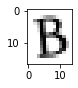

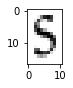

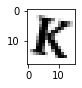

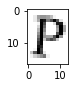

In [172]:
for img_path in save_paths:
  letter_image = cv2.imread(img_path)
  plt.figure(figsize=(2,1))
  plt.imshow(letter_image)

Our letters are nicely organized! Now let's put it all together in one big happy loop family.

In [173]:
import os
import cv2
import glob
import imutils


CAPTCHA_IMAGE_FOLDER = os.path.join("drive", "MyDrive", "colab-data", "generated_captcha_images")
OUTPUT_FOLDER = "extracted_letter_images"


# Get a list of all the captcha images we need to process
captcha_image_files = glob.glob(os.path.join(CAPTCHA_IMAGE_FOLDER, "*"))
counts = {}

# loop over the image paths
for (i, captcha_image_file) in enumerate(captcha_image_files):
    print("[INFO] processing image {}/{}".format(i + 1, len(captcha_image_files)))

    # Since the filename contains the captcha text (i.e. "2A2X.png" has the text "2A2X"),
    # grab the base filename as the text
    filename = os.path.basename(captcha_image_file)
    captcha_correct_text = os.path.splitext(filename)[0]

    # Load the image and convert it to grayscale
    image = cv2.imread(captcha_image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Add some extra padding around the image
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

    # threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # find the contours (continuous blobs of pixels) the image
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Hack for compatibility with different OpenCV versions
    contours = contours[0]

    letter_image_regions = []

    # Now we can loop through each of the four contours and extract the letter
    # inside of each one
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # Compare the width and height of the contour to detect letters that
        # are conjoined into one chunk
        if w / h > 1.25:
            # This contour is too wide to be a single letter!
            # Split it in half into two letter regions!
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            # This is a normal letter by itself
            letter_image_regions.append((x, y, w, h))

    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    if len(letter_image_regions) != 4:
        continue

    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    # Save out each letter as a single image
    for letter_bounding_box, letter_text in zip(letter_image_regions, captcha_correct_text):
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]

        # Get the folder to save the image in
        save_path = os.path.join(OUTPUT_FOLDER, letter_text)

        # if the output directory does not exist, create it
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # write the letter image to a file
        count = counts.get(letter_text, 1)
        p = os.path.join(save_path, "{}.png".format(str(count).zfill(6)))
        cv2.imwrite(p, letter_image)

        # increment the count for the current key
        counts[letter_text] = count + 1


Streaming output truncated to the last 5000 lines.
[INFO] processing image 4956/9955
[INFO] processing image 4957/9955
[INFO] processing image 4958/9955
[INFO] processing image 4959/9955
[INFO] processing image 4960/9955
[INFO] processing image 4961/9955
[INFO] processing image 4962/9955
[INFO] processing image 4963/9955
[INFO] processing image 4964/9955
[INFO] processing image 4965/9955
[INFO] processing image 4966/9955
[INFO] processing image 4967/9955
[INFO] processing image 4968/9955
[INFO] processing image 4969/9955
[INFO] processing image 4970/9955
[INFO] processing image 4971/9955
[INFO] processing image 4972/9955
[INFO] processing image 4973/9955
[INFO] processing image 4974/9955
[INFO] processing image 4975/9955
[INFO] processing image 4976/9955
[INFO] processing image 4977/9955
[INFO] processing image 4978/9955
[INFO] processing image 4979/9955
[INFO] processing image 4980/9955
[INFO] processing image 4981/9955
[INFO] processing image 4982/9955
[INFO] processing image 4983/99

In [193]:
!cp -r extracted_letter_images/ drive/MyDrive/colab-data/extracted_letter_images

# Setting up our ML Algorithm

We've prepared the data, and now the exciting part, we're going to build and train a really (really) simple network to classify our letters. As we already know, recognizing single letters really isn't hard - you don't even actually need CNNs for it! However, CNNs help quite a bit, and we have to assume that these days, the captchas would be harder to crack then these fellas. So let's build a CNN!

Before we actually build the network, we're going to prepare our data to load into it. Our images need to be the same size, so we'll have to resize them. Here's a function you downloaded off the web to resize your images for machine learning.

In [179]:
import imutils
import cv2


def resize_to_fit(image, width, height):
    """
    A helper function to resize an image to fit within a given size
    :param image: image to resize
    :param width: desired width in pixels
    :param height: desired height in pixels
    :return: the resized image
    """

    # grab the dimensions of the image, then initialize
    # the padding values
    (h, w) = image.shape[:2]

    # if the width is greater than the height then resize along
    # the width
    if w > h:
        image = imutils.resize(image, width=width)

    # otherwise, the height is greater than the width so resize
    # along the height
    else:
        image = imutils.resize(image, height=height)

    # determine the padding values for the width and height to
    # obtain the target dimensions
    padW = int((width - image.shape[1]) / 2.0)
    padH = int((height - image.shape[0]) / 2.0)

    # pad the image then apply one more resizing to handle any
    # rounding issues
    image = cv2.copyMakeBorder(image, padH, padH, padW, padW,
        cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (width, height))

    # return the pre-processed image
    return image

Now, we want to load all of our images and labels (this is a pretty small dataset so loading it all at once into RAM is fine).

In [180]:
import numpy as np
from imutils import paths

LETTER_IMAGES_FOLDER = "extracted_letter_images"
MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"


# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 20x20 pixel box
    image = resize_to_fit(image, 20, 20)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)


# scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

It's prepared. Now let's split the test and training sets

In [182]:
from sklearn.model_selection import train_test_split

(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

In [185]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer
import pickle

In [186]:
# Convert the labels (letters) into one-hot encodings that Keras can work with
lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)

# Save the mapping from labels to one-hot encodings.
# We'll need this later when we use the model to decode what it's predictions mean
with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)

In [187]:
# Build the neural network!
model = keras.Sequential()

# First convolutional layer with max pooling
model.add(keras.layers.Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Second convolutional layer with max pooling
model.add(keras.layers.Conv2D(50, (5, 5), padding="same", activation="relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Hidden layer with 500 nodes
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(500, activation="relu"))

# Output layer with 32 nodes (one for each possible letter/number we predict)
model.add(keras.layers.Dense(32, activation="softmax"))

# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

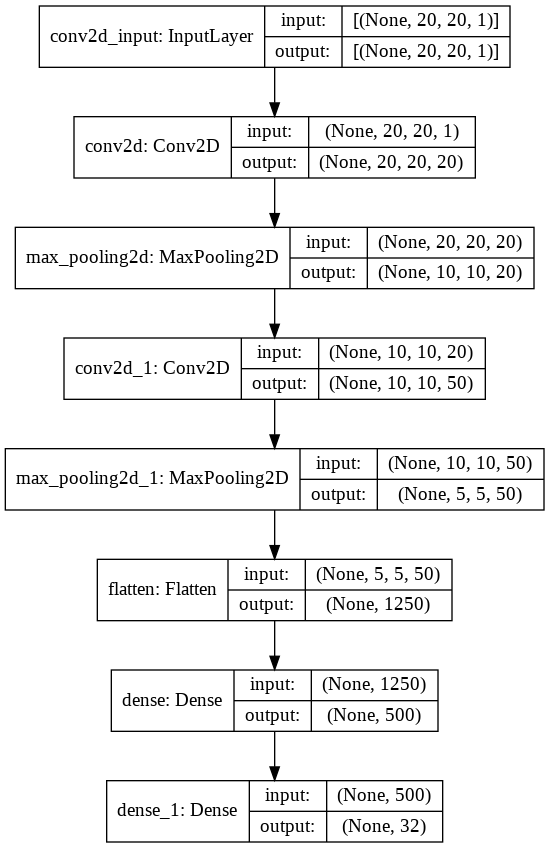

In [190]:
keras.utils.plot_model(model, show_shapes=True)

In [191]:
# Train the neural network
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=10, verbose=1)

# Save the trained model to disk
model.save(MODEL_FILENAME)


Epoch 1/10
909/909 [==============================] - 34s 36ms/step - loss: 0.7290 - accuracy: 0.8127 - val_loss: 0.0214 - val_accuracy: 0.9961
Epoch 2/10
909/909 [==============================] - 32s 36ms/step - loss: 0.0166 - accuracy: 0.9962 - val_loss: 0.0335 - val_accuracy: 0.9908
Epoch 3/10
909/909 [==============================] - 33s 36ms/step - loss: 0.0058 - accuracy: 0.9985 - val_loss: 0.0097 - val_accuracy: 0.9975
Epoch 4/10
909/909 [==============================] - 33s 36ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.0058 - val_accuracy: 0.9986
Epoch 5/10
909/909 [==============================] - 33s 36ms/step - loss: 0.0033 - accuracy: 0.9989 - val_loss: 0.0107 - val_accuracy: 0.9979
Epoch 6/10
909/909 [==============================] - 33s 36ms/step - loss: 0.0046 - accuracy: 0.9984 - val_loss: 0.0123 - val_accuracy: 0.9971
Epoch 7/10
909/909 [==============================] - 33s 36ms/step - loss: 7.3754e-04 - accuracy: 0.9999 - val_loss: 0.0103 - val_accur

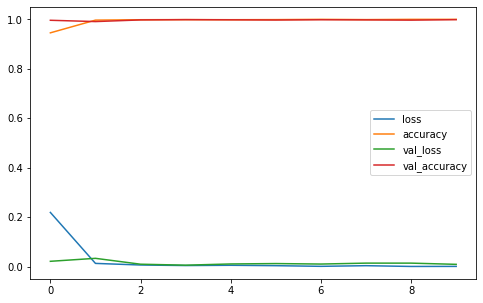

In [192]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5))